# Applied ML 207 Final Project

## Human or Robot?

by

Alexandra Savelieva, Bryan Auyeung & Vasanth Ramani

## 1. Introduction

In this Kaggle challenge, we're chasing down robots for an online auction site. Human bidders on the site are becoming increasingly frustrated with their inability to win auctions vs. their software-controlled counterparts. As a result, usage from the site's core customer base is plummeting.

In order to rebuild customer happiness, the site owners need to eliminate computer generated bidding from their auctions. Their attempt at building a model to identify these bids using behavioral data, including bid frequency over short periods of time, has proven insufficient. 

The goal of this competition is to identify online auction bids that are placed by "robots", helping the site owners easily flag these users for removal from their site to prevent unfair auction activity. 

### 1.1 Hypothesis

We want to build a classifier that accurately identifies robots from human bidders.



### 1.2 Dataset

* train.csv - the training set from the bidder dataset (with labels)

* test.csv - the test set from the bidder dataset (not important for our purposes)

* sampleSubmission.csv - a sample submission file in the correct format (not important for our purposes)

* bids.csv - the bid dataset


##### 1.2.1 Bidder Dataset

* bidder_id – Unique identifier of a bidder.

* payment_account – Payment account associated with a bidder. These are obfuscated to protect privacy. 

* address – Mailing address of a bidder. These are obfuscated to protect privacy. 

* outcome – Label of a bidder indicating whether or not it is a robot. Value 1.0 indicates a robot, where value 0.0 indicates human. 

The outcome was half hand labeled, half stats-based. There are two types of "bots" with different levels of proof:

1. Bidders who are identified as bots/fraudulent with clear proof. Their accounts were banned by the auction site.

2. Bidder who may have just started their business/clicks or their stats exceed from system wide average. There are no clear proof that they are bots. 


##### 1.2.2 Bids Dataset

* bid_id - unique id for this bid 

* bidder_id – Unique identifier of a bidder (same as the bidder_id used in train.csv and test.csv) 
 
* auction – Unique identifier of an auction 

* merchandise –  The category of the auction site campaign, which means the bidder might come to this site by way of searching for "home goods" but ended up bidding for "sporting goods" - and that leads to this field being "home goods". This categorical field could be a search term, or online advertisement.  
* device – Phone model of a visitor 

* time - Time that the bid is made (transformed to protect privacy). 

* country - The country that the IP belongs to  

* ip – IP address of a bidder (obfuscated to protect privacy).  

* url - url where the bidder was referred from (obfuscated to protect privacy). 

## 2. General methodology
We will clean the data and perform EDA. We start with treating the dataset as a “black box”, without applying any domain knowledge to feature engineering. We will use this information to determine our baseline. Also we will compare it with a very naive algorithm - “what if we answer that it is human regardless of the feature values”.
* Denormalize data and label the ‘bids’ dataset with the bidder information and outcome (i.e. join by key - bidder id).
* Create new features that aggregate total values by bidder_id and add them to our bids dataset for future models. We will add more complex features following the completion of the baseline.
* Use a KNN model as a baseline to classify humans and bots from our merged dataset. For this, we need to transform categorical data into numeric values.
* Further improve our accuracy with better algorithms such as decision trees with ADA/gradient boosting, random forest classifiers, logistic regression.
* Given that several features in the dataset are obfuscated for privacy concerns, consider engineering more insights from bids (such as frequency, geo-distribution, IP-distribution) per bidder to improve our accuracy.

In [0]:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth 
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
bidslink = 'https://drive.google.com/open?id=16m_IzfTRAQFuEJ2D704pjv-D9XWdVjIY'
fluff, id = bidslink.split('=')
downloaded1 = drive.CreateFile({'id':id})
downloaded1.GetContentFile('bids.csv')
trainlink = 'https://drive.google.com/open?id=1S3p0sTrX5N9K_QaPrDT3vP3ZyCHePuTm'
fluff, id = trainlink.split('=')
downloaded2 = drive.CreateFile({'id':id})
downloaded2.GetContentFile('train.csv')

***

## 3. Imports

In [0]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn import preprocessing

# Import train_test_split function
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#Import KNN model
from sklearn.neighbors import KNeighborsClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# AUC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# ignore the warning
import warnings
warnings.filterwarnings('ignore')

***

## 4. Preprocess Data

### 4.1 Exploring the bids dataset

In [88]:
bids = pd.read_csv("bids.csv") 
bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [89]:
print('Number of unique bidders -', len(bids.bidder_id.unique()))
print('Number of unique auctions -', len(bids.auction.unique()))

# Looks like many things are bought at the same time. How is this time transformed (hour / minute?) 
print('Unique bids at the same time -', len(bids.time.unique()))
print('Bids at the same time -', len(bids.time))

Number of unique bidders - 6614
Number of unique auctions - 15051
Unique bids at the same time - 776529
Bids at the same time - 7656334


Look at the distribution of merchandise that is being bought in the auction.

Unique merchandise - ['jewelry' 'furniture' 'home goods' 'mobile' 'sporting goods'
 'office equipment' 'computers' 'books and music' 'clothing' 'auto parts']


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

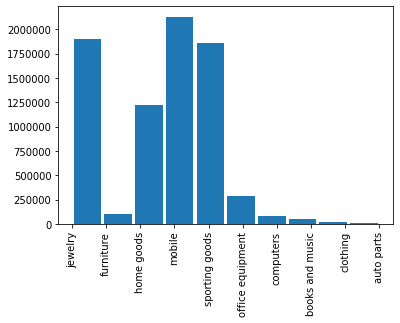

In [90]:
print('Unique merchandise -', bids.merchandise.unique())
plt.hist(bids.merchandise, rwidth=.9)
plt.xticks(rotation='vertical')

### 4.2 Exploring the train dataset

In [91]:
train = pd.read_csv('train.csv')
print('Columns in Train dataset -', train.columns)
print('Total unique bidders -', len(train.bidder_id.unique()))

Columns in Train dataset - Index(['bidder_id', 'payment_account', 'address', 'outcome'], dtype='object')
Total unique bidders - 2013


In [92]:
print(train.head())

                               bidder_id  ... outcome
0  91a3c57b13234af24875c56fb7e2b2f4rb56a  ...     0.0
1  624f258b49e77713fc34034560f93fb3hu3jo  ...     0.0
2  1c5f4fc669099bfbfac515cd26997bd12ruaj  ...     0.0
3  4bee9aba2abda51bf43d639013d6efe12iycd  ...     0.0
4  4ab12bc61c82ddd9c2d65e60555808acqgos1  ...     0.0

[5 rows x 4 columns]


In [93]:
print('Total Outcomes -' ,train.outcome.value_counts())

# Percent of robots in the entire dataset
print("Robot/Human -", train.outcome.value_counts()[1]/train.outcome.value_counts()[0]) #412416/2658837 

Total Outcomes - 0.0    1910
1.0     103
Name: outcome, dtype: int64
Robot/Human - 0.05392670157068063


### 4.3 Data Cleaning

We see that there are some empty values inside the Country column in the bids dataframe.

In [94]:
pd.isnull(bids).any()

bid_id         False
bidder_id      False
auction        False
merchandise    False
device         False
time           False
country         True
ip             False
url            False
dtype: bool

We are finding 29 bidder Ids in the train dataset that are not in the bids dataset. Finding the bid_ids that are not null

In [95]:
def Diff(li1, li2): 
    return (list(set(li1) - set(li2)))

li1 = bids.bidder_id.unique()
li2 = train.bidder_id.unique()
difference = (len(Diff(li1, li2)))

# Difference in unique bidder_ids
print('Overlap in unique bidder ID between bids and train data is -', len(bids.bidder_id.unique())- difference)
print('Train data has unique bidder IDs -', len(train.bidder_id.unique()))

difference2 = (len(Diff(li2, li1)))
# Difference in bid_ids
print("There are ", difference, "bidder id's that are in (unlabeled) bids dataset but not in (labeled) bidders dataset")
print("There are ", difference2, "bidder id's that are in (labeled) bidders dataset but not in (unlabeled) bids dataset")


Overlap in unique bidder ID between bids and train data is - 1984
Train data has unique bidder IDs - 2013
There are  4630 bidder id's that are in (unlabeled) bids dataset but not in (labeled) bidders dataset
There are  29 bidder id's that are in (labeled) bidders dataset but not in (unlabeled) bids dataset


Dropping the Not Applicable(NA) rows

In [0]:
bids = bids.dropna()

*******

## 5. Analysis and Feature Engineering

### 5.1 Identifying new features


To understand bidder data, we will aggregate features by their respective bidder ids into a separate table.

We merge the new table to the train data, where bidder ID is provided.

In [97]:
def add_grouping_to_bidder(column,train_extended):
  temp_totalvalues=bids.groupby('bidder_id')[column].nunique()
  train_extended= pd.merge(train_extended, temp_totalvalues, on='bidder_id', how='left')
  new_column_name=column+'_count'
  train_extended.rename(columns = {column:new_column_name}, inplace = True) 
  return train_extended

group_count_columns = ['bid_id','time','merchandise', 'auction', 'url', 'device', 'ip', 'country']
train_extended=train.copy()
for column in group_count_columns: 
    train_extended=add_grouping_to_bidder(column,train_extended) 

train_extended.head()

,bidder_id,payment_account,address,outcome,bid_id_count,time_count,merchandise_count,auction_count,url_count,device_count,ip_count,country_count
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,24.0,24.0,1.0,18.0,1.0,14.0,20.0,6.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,3.0,3.0,1.0,1.0,2.0,2.0,3.0,1.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4.0,4.0,1.0,4.0,2.0,2.0,4.0,1.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,155.0,155.0,1.0,23.0,91.0,53.0,123.0,2.0


### 5.2 Rebalancing the skewed records

We are finding a total of 1983 records out of which 1880 are human bidders and 103 are identified as Bots. When we apply the model on this biased data, we got higher accuracy, but we noticed that the model was not able to identify the Bots correctly. This was due to underfitting with high bias towards skewed human outcome. Therefore, we will rebalance the records to prevent this issue.

In [114]:
print("train_extended dataset size before drop NA -", len(train_extended))
train_extended = train_extended.dropna()
print("train_extended dataset size after drop NA -", len(train_extended))

bots_train = train_extended.loc[train_extended.outcome == 1]
print('Number of Rows with Bots outcome -', len(bots_train))
human_train = train_extended.loc[train_extended.outcome == 0]
print('Number of Rows with Human outcome -',len(human_train))
human_sample = human_train.sample(n=len(bots_train), random_state=100)
bid_train_balance = pd.concat([bots_train, human_sample])

print('Total records -', len(bid_train_balance))

train_extended dataset size before drop NA - 1983
train_extended dataset size after drop NA - 1983
Number of Rows with Bots outcome - 103
Number of Rows with Human outcome - 1880
Total records - 206


Drop unnecessary obfuscated features that should not impact our baseline model. Transforming the categorical data to integers. Create the training and test set at a 70:30 ratio.

In [107]:
def transform_categorical(column_name):    
  le = preprocessing.LabelEncoder()
  bid_train_balance[column_name]= le.fit_transform((bid_train_balance[column_name].astype(str)))

# Transform the bidder_id column into integers
columns = ['bidder_id']
for column in columns: 
    transform_categorical(column) 

bid_train_balance.drop(['payment_account', 'address'], axis=1, inplace=True)

X, Y = bid_train_balance.loc[:, bid_train_balance.columns != 'outcome' ], bid_train_balance['outcome']

#Split dataset into 70% training set and 30% test set
train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size=0.3,random_state=109) 

print("Train dataset size -", len(train_labels))
print("Test dataset size -", len(test_labels)) 
X.head()

Train dataset size - 144
Test dataset size - 62


,bidder_id,bid_id_count,time_count,merchandise_count,auction_count,url_count,device_count,ip_count,country_count
21,67,181.0,181.0,1.0,18.0,1.0,51.0,13.0,7.0
50,123,6513.0,6455.0,1.0,269.0,1909.0,408.0,3441.0,65.0
51,139,2048.0,2044.0,1.0,127.0,5.0,24.0,358.0,14.0
58,84,281.0,277.0,1.0,26.0,7.0,1.0,8.0,2.0
77,22,1103.0,1095.0,1.0,107.0,4.0,4.0,836.0,29.0


*******

## 6. Baseline Model

We will be using the KNN model to predict the bidder by fitting the training data and evaluating its accuracy. The first step in this model is to find the best K. 

We will explore the options below to find the best value for the hyperparameter K.


The optimal number of neighbors is 7


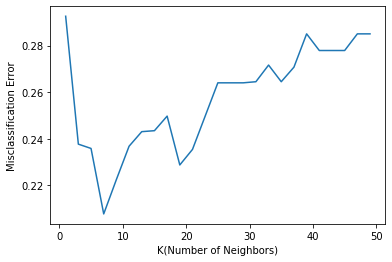

In [108]:
# creating odd list of K for KNN from 1-50
neighbors = list(range(1, 50, 2))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    neigh = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(neigh, train_data, train_labels, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
best_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbors is {}".format(best_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("K(Number of Neighbors)")
plt.ylabel("Misclassification Error")
plt.show()

Once we find the best K using cross validation, we will use it to fit the model

In [109]:
start_time = time.time()
neigh = KNeighborsClassifier(best_k)
neigh.fit(train_data, train_labels) 
y_pred =neigh.predict(test_data)
end_time =  time.time()
elapsed_time = end_time - start_time
print('Elapsed Time -', elapsed_time, ' seconds')   

Elapsed Time - 0.010819673538208008  seconds


*******

## 7. Evaluating the model

### 7.1 Precision, Recall and F1-score

The model can be evaluated using Precision, Recall and f1-scores

In [110]:
report=classification_report(test_labels, y_pred, output_dict=True)
print(classification_report(test_labels, y_pred))
precision = metrics.precision_score(test_labels, y_pred)
recall = metrics.recall_score(test_labels, y_pred)
f1score = metrics.f1_score(test_labels, y_pred)

              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87        30
         1.0       0.88      0.88      0.88        32

    accuracy                           0.87        62
   macro avg       0.87      0.87      0.87        62
weighted avg       0.87      0.87      0.87        62



### 7.2 Accuracy

Let us compute the accuracy of this model

In [111]:
accuracy = report.get('accuracy')
print("Accuracy score -",accuracy) 

Accuracy score - 0.8709677419354839


### 7.3 AUC & ROC

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. 


ROC Score - 0.8708333333333333


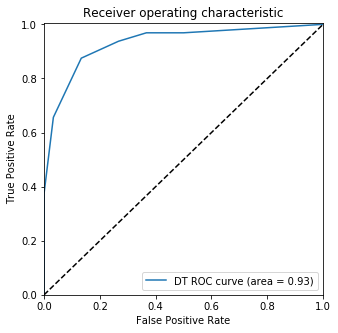

In [112]:
roc = metrics.roc_auc_score(test_labels, y_pred)
print('ROC Score -', roc)

y_dt_score = neigh.predict_proba(test_data)[:, 1]
fpr_dt, tpr_dt, _dt = roc_curve(test_labels, y_dt_score)
roc_dt_auc = auc(fpr_dt, tpr_dt)
fig = plt.figure(figsize=(5, 5))
plt.plot(fpr_dt, tpr_dt, label='DT ROC curve (area = %0.2f)' % roc_dt_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
fig.savefig('roc_dt_auc.png')

## 8. Challenges and workarounds
### Challenge 1: trustworthiness of the labels
According to the disclaimer on the website, the labels are not 100% trustworthy. There may be some bots mislabels as humans and vice versa. This is especially true for new bidders: 
The outcome was half hand labeled, half stats-based. There are two types of "bots" with different levels of proof:
1. Bidders who are identified as bots/fraudulent with clear proof. Their accounts were banned by the auction site.
2. Bidder who may have just started their business/clicks or their stats exceed from system wide average. There are no clear proof that they are bots. 
**Possible workarounds:**

From the provided dataset, can we distinguish “just started” from the rest? If yes, how much of the data set they constitute? 
Can we build clusters to improve the labeling? 

### Challenge 2: obfuscation for privacy protection 
Since IP’s, referrer URL’s, device types, andtime are obfuscated to protect privacy, we cannot rely on them to infer which country the user is accessing the auction platform from. It will be difficult to perform text analysis on referrer URLs as they are replaced with some hash-like data structures.

**Possible workarounds:**

There is a separate ‘country’ field which hopefully would compensate for this limitation
Hence, we may derive features from IP’s (e.g. look at IP as a whole and its prefix, also look at the combination of country and ip prefix as it’s possible that some bidders are spoofing IPs
There are some urls that match across different bidders. So we can build a dictionary with one word = one url and sparse matrix for bids and / or bidders indicating if they were used as referrers
Time was transformed but hopefully it preserved ‘bot patterns’ 

### Challenge 3: Unclean Data

Some of the data is missing from our bids and training dataset. For the available training dataset, we have missing information corresponding to the bidder’s placed bids. This also occurs with our bids dataset, where bidder metadata and outcome is unavailable. 

**Possible workarounds:**

We removed NAs from our data after merging data that contained features/entries from both datasets. Then we transformed our categorical name data into numerical data for modelling purposes. 
We engineered new features from our dataset and will continue to improve the feature set to train our models.


## 9. Conclusion

As we can see below, this base KNN model is reasonbly fast and good in terms of accuracy. We will try to compare with other algorithms and see if the performance improves the performance further.

In [113]:
knn_metrics = [accuracy, precision, recall, f1score, roc, elaped_time]

label = ["Accuracy_score", "Precision_score",
         "Recall_Score", "F1_score", "ROC_AUC_score", "Time(s)"]
table = pd.DataFrame({'KNN Model': knn_metrics})

table = table.transpose()
table.columns = label
table.transpose().round(3)

,KNN Model
Accuracy_score,0.871
Precision_score,0.875
Recall_Score,0.875
F1_score,0.875
ROC_AUC_score,0.871
Time(s),0.028


*******